# Applying Smoothing Filters in EEG - Neuroscience

### A) Average Filter 
### B) Gaussian Filter 
### C) Median Filter 

## Import libraries

To install libraries in Python, you can use a package manager like pip, which comes pre-installed with most Python distributions.



In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal

## Import Dataset

In [2]:
# load the Excel file as a DataFrame
eeg_data = pd.read_excel("/kaggle/input/dataset-with-channels-for-eeg-visualization/dataset.xlsx")
display(eeg_data)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3
...,...,...,...,...,...,...,...,...
7115,23896.6,3893.1,37567.5,38276.6,11183.1,4515.5,31611.9,48532.8
7116,23850.2,3780.5,37514.3,38075.4,11119.7,4572.2,31551.9,48566.2
7117,23766.2,3644.2,37432.3,37477.1,11029.8,4755.0,31464.2,47165.5
7118,23768.4,3709.8,37443.6,37362.9,11048.4,4738.0,31481.5,46410.0


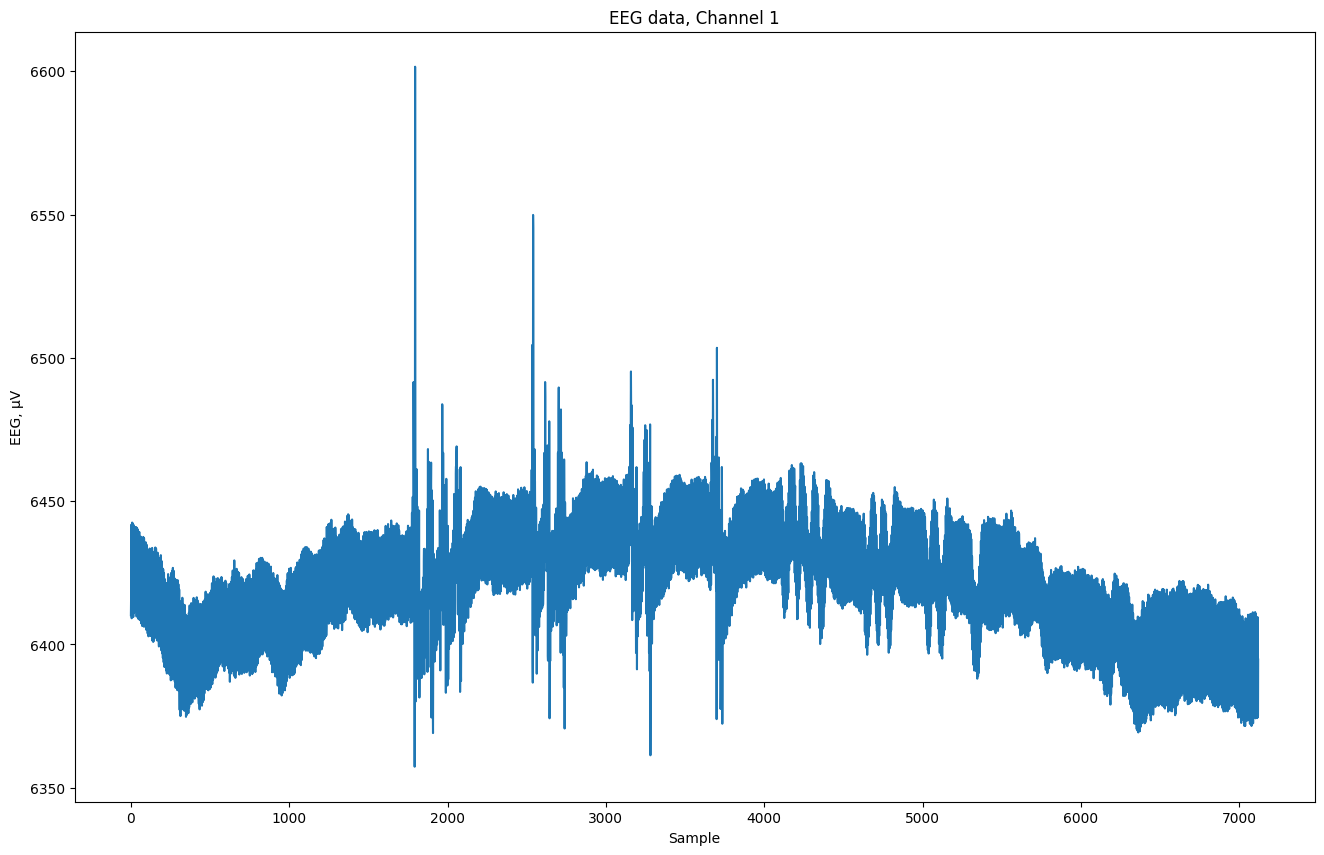

In [3]:
# select the data from the first channel
channel = 0
first_channel_data = eeg_data.iloc[:, channel]
first_channel_data = round(1000000*4.5*(first_channel_data/16777215),2)  # Convert data from ADC to µV

# plot the EEG data
fig, ax = plt.subplots(1, figsize=(16,10))
plt.plot(first_channel_data)
plt.title("EEG data, Channel " + str(channel+1))
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

## Band Pass Filter

Band-pass filtering is a common signal processing technique used in EEG (Electroencephalography) data analysis to isolate specific frequency bands of interest while removing unwanted frequencies. Band-pass filtering allows researchers to focus on particular brainwave rhythms that are relevant to their study. For example, you might want to extract the alpha, beta, or gamma waves from the EEG data.  

You can read more about the band-pass filter in [Chapter 1](https://graceful-kelpie-579688.netlify.app/chapters/chapter_1-band_pass_filter).

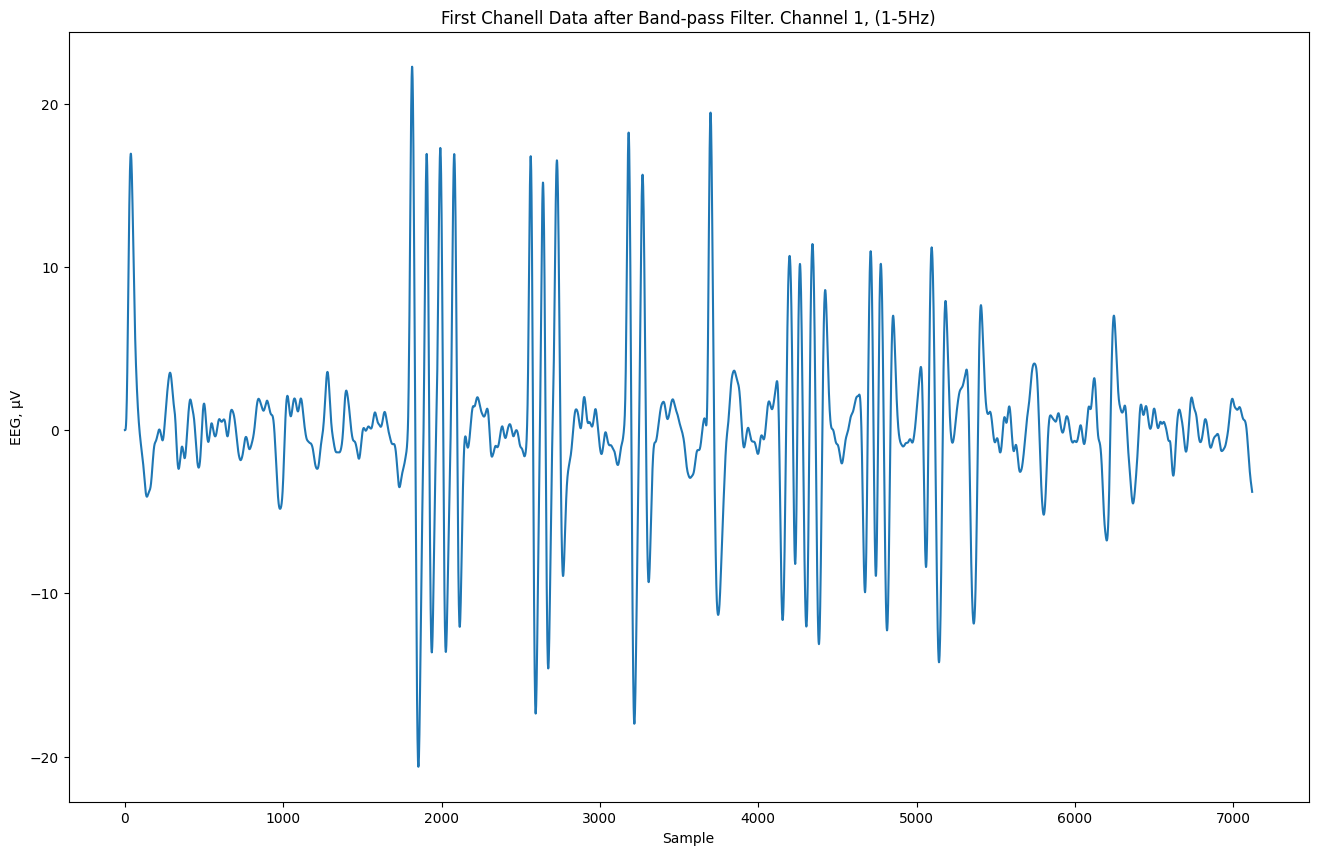

In [4]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

first_channel_data_bp_filtered = first_channel_data.copy()  # copy the data

fps = 250  # sampling frequency
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 5  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
first_channel_data_bp_filtered = butter_highpass_filter(
    data=first_channel_data_bp_filtered,
    cutoff=cutoff_high,
    nyq=nyq,
    order=5)

first_channel_data_bp_filtered = butter_lowpass_filter(
    data=first_channel_data_bp_filtered,
    cutoff=cutoff_low,
    nyq=nyq,
    order=4)

fig, ax = plt.subplots(1, figsize=(16,10))
plt.plot(first_channel_data_bp_filtered)
plt.title("First Chanell Data after Band-pass Filter. Channel " +  str(channel+1) +", ("+str(cutoff_high)+"-"+str(cutoff_low) + "Hz)")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.show()

## Smoothing filters

Smoothing filters are essential tools in EEG signal processing, used to reduce noise and highlight underlying patterns. These filters work by averaging or weighting neighboring data points to create a smoother representation of the signal. 
The average filter computes the mean of nearby samples, reducing high-frequency noise.

## Average filter

In signal processing of EEG (Electroencephalography) data, calculating the average is a common technique used to improve the signal-to-noise ratio and highlight underlying brain activity. The EEG signal is often contaminated with noise and artifacts, and averaging can help reduce these unwanted components while preserving the brain-related activity.   

**Positive**  

* An average filter can effectively smooth out the EEG signal **by removing high-frequency noise and minor fluctuations**.
* Easy to implement
* EEG signals often *exhibit slow oscillatory patterns*, such as **alpha**, **beta**, and **delta waves**.
  - Applying an average filter with a longer time window can help visualize these slower frequency components by attenuating faster fluctuations

**Negative**

* *Temporal Resolution*. Applying an average filter with a large window can smooth out fine temporal details and fast changes in the EEG signal. Depending on your analysis goals, this may or may not be desirable.

* *Signal Distortion*. Over-smoothing can lead to the loss of important signal features, including transient responses or rapid changes that might be critical for your analysis.

* *Baseline Fluctuations*. If analysis involves comparing EEG activity before and after specific events, excessive smoothing can reduce the detectable differences in baseline fluctuations.

**How it works**  

An average filter for EEG works by smoothing out the signal by replacing each data point with the average value of neighboring data points within a defined window. Need to choose an appropriate window size to balance noise reduction with preserving important signal features.

*Note that data on the plots is zoomed in to better see the effect of the filters.*

In [5]:
def average_filter(data, average_length):
    """Average filter.
    Args:
        data (array_like): data to be filtered.
        average_length (int): length of the filter window.
    Returns:
        array: filtered data."""
    data = pd.DataFrame(data)
    avereged_data = data.rolling(window=average_length).mean()
    return avereged_data

In [6]:
# you can control the "smoothness" of the data by changing the window size
average_length_window_1 = 40
average_length_window_2 = 70

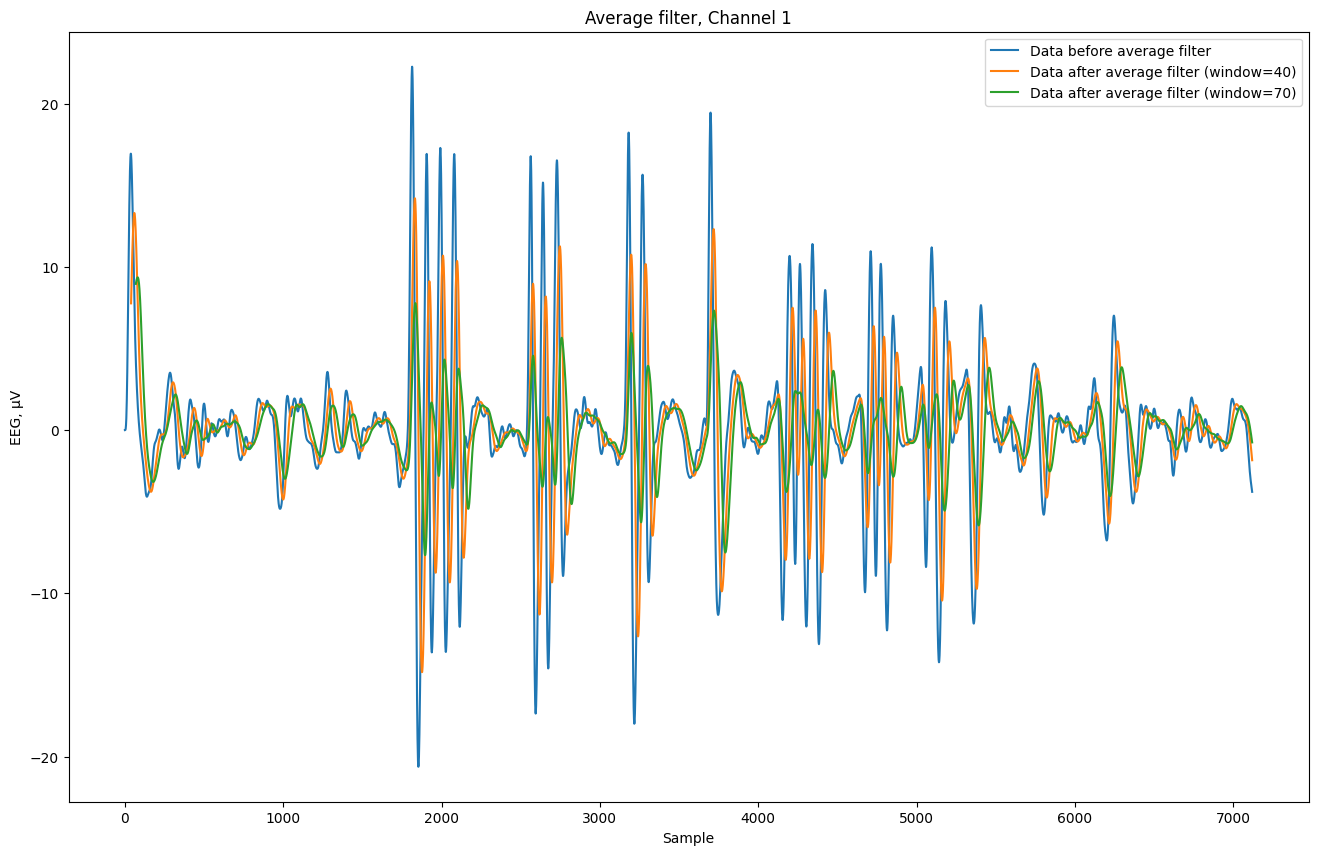

In [7]:
channel_data_avg_window_1 = average_filter(data=first_channel_data_bp_filtered, average_length=average_length_window_1)
channel_data_avg_window_2 = average_filter(data=first_channel_data_bp_filtered, average_length=average_length_window_2)

fig, ax = plt.subplots(1, figsize=(16,10))
plt.title("Average filter, Channel " +  str(channel+1))
plt.plot(first_channel_data_bp_filtered, label='Data before average filter')
plt.plot(channel_data_avg_window_1, label='Data after average filter (window='+str(average_length_window_1)+")")
plt.plot(channel_data_avg_window_2, label='Data after average filter (window='+str(average_length_window_2)+")")
plt.ylabel('EEG, µV')
plt.xlabel('Sample')
plt.legend(loc='upper right')
# plt.xlim([0, 2000])  # zoom in the data
plt.show()

**Larger average lengths** increase the filter's effect, reducing noise but also potentially removing important details and features. This can be useful for very noisy images but may degrade image quality by oversmoothing. The **Expected Observation:** The image will retain more details and sharpness. Only minor smoothing will occur as fewer pixel values are averaged.  

**Smaller average lengths**: provide less smoothing, which helps preserve image details while still reducing some noise. This is beneficial when it is important to maintain edge details and fine structures.

### Let's make it clear...

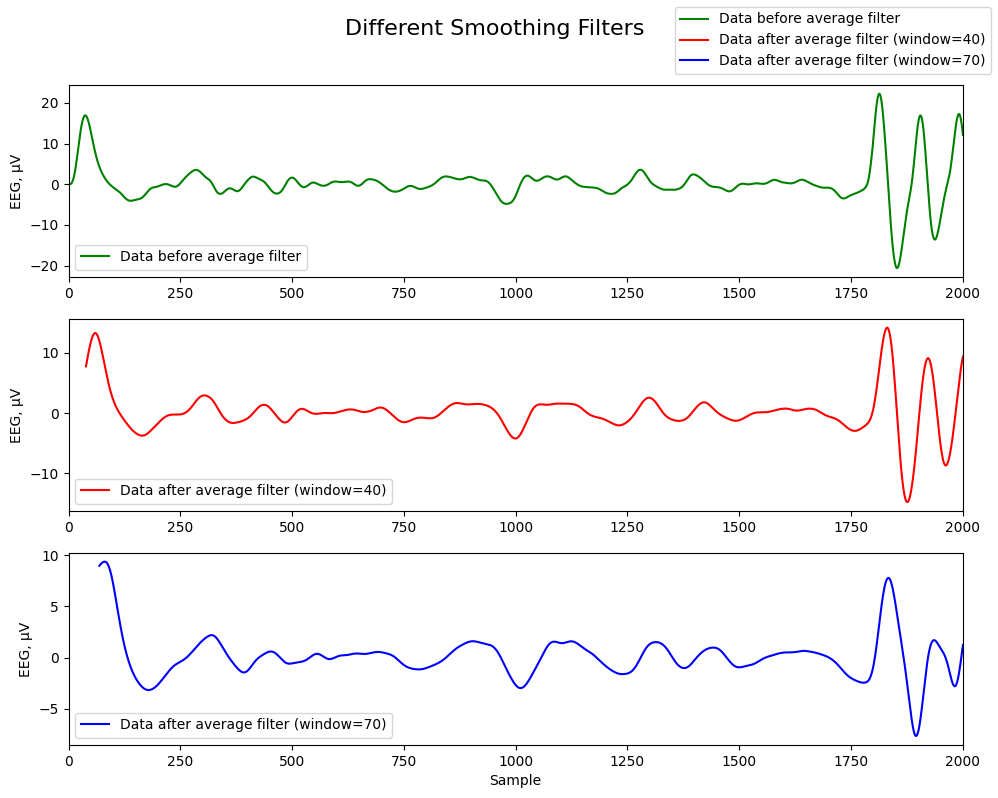

In [8]:
fig, axs = plt.subplots(3,1, figsize=(10,8))

fig.suptitle('Different Smoothing Filters', fontsize=16)

axs[0].plot(first_channel_data_bp_filtered, 
            label='Data before average filter', 
            c='green')
axs[1].plot(channel_data_avg_window_1, 
            c='red',
            label='Data after average filter (window='+str(average_length_window_1)+")")
axs[2].plot(channel_data_avg_window_2, 
            c='blue',
            label='Data after average filter (window='+str(average_length_window_2)+")")

for ax in axs:
    ax.set_xlim([0, 2000])
    ax.legend(fontsize=10)
    ax.set_ylabel('EEG, µV')

axs[-1].set_xlabel('Sample')

fig.legend(loc='upper right')
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the Title
plt.show()

### Convert all the data from the dataframe from ADC to µV
- We have converted the data only from our first channel, now we will convert all the data and get it all into one dataframe.
- Then we will use the Band pass filters in all the data frame

In [9]:
eeg_data = round(1000000*4.5*(eeg_data/16777216),2) # 2 to the power of 24 = 16777216
display(eeg_data)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,6410.24,791.55,9774.56,10304.67,3329.94,1008.38,8315.22,14155.44
1,6415.23,817.54,9780.35,10284.74,3338.84,999.47,8323.54,14007.41
2,6433.25,844.41,9796.80,10461.31,3358.23,965.94,8342.53,14262.67
3,6441.81,853.83,9803.88,10622.30,3365.77,931.53,8350.57,14621.96
4,6426.65,821.02,9788.67,10529.52,3346.22,952.10,8331.45,14570.11
...,...,...,...,...,...,...,...,...
7115,6409.57,1044.21,10076.39,10266.58,2999.54,1211.15,8478.97,13017.51
7116,6397.12,1014.01,10062.12,10212.62,2982.54,1226.36,8462.88,13026.47
7117,6374.59,977.45,10040.13,10052.14,2958.42,1275.39,8439.36,12650.77
7118,6375.18,995.05,10043.16,10021.51,2963.41,1270.83,8444.00,12448.13


### Band Pass Filter filter the whole dataset
##### Here we convert ALL the EEG data after filtering to Pandas format dataset

In [10]:
eeg_data_bp_filtered = eeg_data.copy()

for channel in range(eeg_data.shape[1]):
    eeg_data_bp_filtered.iloc[:, channel] = butter_highpass_filter(
        data=eeg_data.iloc[:, channel],
        cutoff=cutoff_high,
        nyq=nyq,
        order=5)
    eeg_data_bp_filtered.iloc[:, channel] = butter_lowpass_filter(
        data=eeg_data_bp_filtered.iloc[:, channel],
        cutoff=cutoff_low,
        nyq=nyq,
        order=4)

# This is the egg_data after the pass band filter
eeg_data_bp_filtered

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,0.000082,0.000128,0.000083,0.000792,0.000095,-0.000170,0.000090,0.001276
1,0.000769,0.001442,0.000792,0.006556,0.000941,-0.001583,0.000883,0.009034
2,0.003853,0.008070,0.003976,0.029509,0.004839,-0.007789,0.004550,0.033917
3,0.013686,0.030162,0.014048,0.099633,0.017333,-0.027453,0.016352,0.100893
4,0.038220,0.085239,0.038851,0.278613,0.048195,-0.077183,0.045659,0.275197
...,...,...,...,...,...,...,...,...
7115,-3.488318,-3.266318,-2.758429,-23.776669,-2.892823,8.096864,-3.052043,-68.107348
7116,-3.561438,-3.648764,-2.825715,-23.784654,-3.081519,8.170567,-3.224695,-65.541265
7117,-3.634774,-4.042718,-2.900259,-23.746583,-3.277758,8.228293,-3.401655,-62.690137
7118,-3.707043,-4.445722,-2.980959,-23.647975,-3.479587,8.267301,-3.580997,-59.513824


### Now we will display the smoothing filters in the whole eeg_data_filtered

#### We will implement the different windows in our data frame

In [11]:
eeg_data_avg_window_1 = average_filter(data=eeg_data_bp_filtered, average_length=average_length_window_1)
eeg_data_avg_window_2 = average_filter(data=eeg_data_bp_filtered, average_length=average_length_window_2)

In [12]:
eeg_data_bp_filtered

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,0.000082,0.000128,0.000083,0.000792,0.000095,-0.000170,0.000090,0.001276
1,0.000769,0.001442,0.000792,0.006556,0.000941,-0.001583,0.000883,0.009034
2,0.003853,0.008070,0.003976,0.029509,0.004839,-0.007789,0.004550,0.033917
3,0.013686,0.030162,0.014048,0.099633,0.017333,-0.027453,0.016352,0.100893
4,0.038220,0.085239,0.038851,0.278613,0.048195,-0.077183,0.045659,0.275197
...,...,...,...,...,...,...,...,...
7115,-3.488318,-3.266318,-2.758429,-23.776669,-2.892823,8.096864,-3.052043,-68.107348
7116,-3.561438,-3.648764,-2.825715,-23.784654,-3.081519,8.170567,-3.224695,-65.541265
7117,-3.634774,-4.042718,-2.900259,-23.746583,-3.277758,8.228293,-3.401655,-62.690137
7118,-3.707043,-4.445722,-2.980959,-23.647975,-3.479587,8.267301,-3.580997,-59.513824


### Let's create an array of colors so we can use it per each channel

In [13]:
channel_colors = [
    '#1f77b4',  # azul
    '#ff7f0e',  # naranja
    '#2ca02c',  # verde
    '#d62728',  # rojo
    '#9467bd',  # violeta
    '#8c564b',  # marrón
    '#e377c2',  # rosa
    '#7f7f7f'   # gris
]

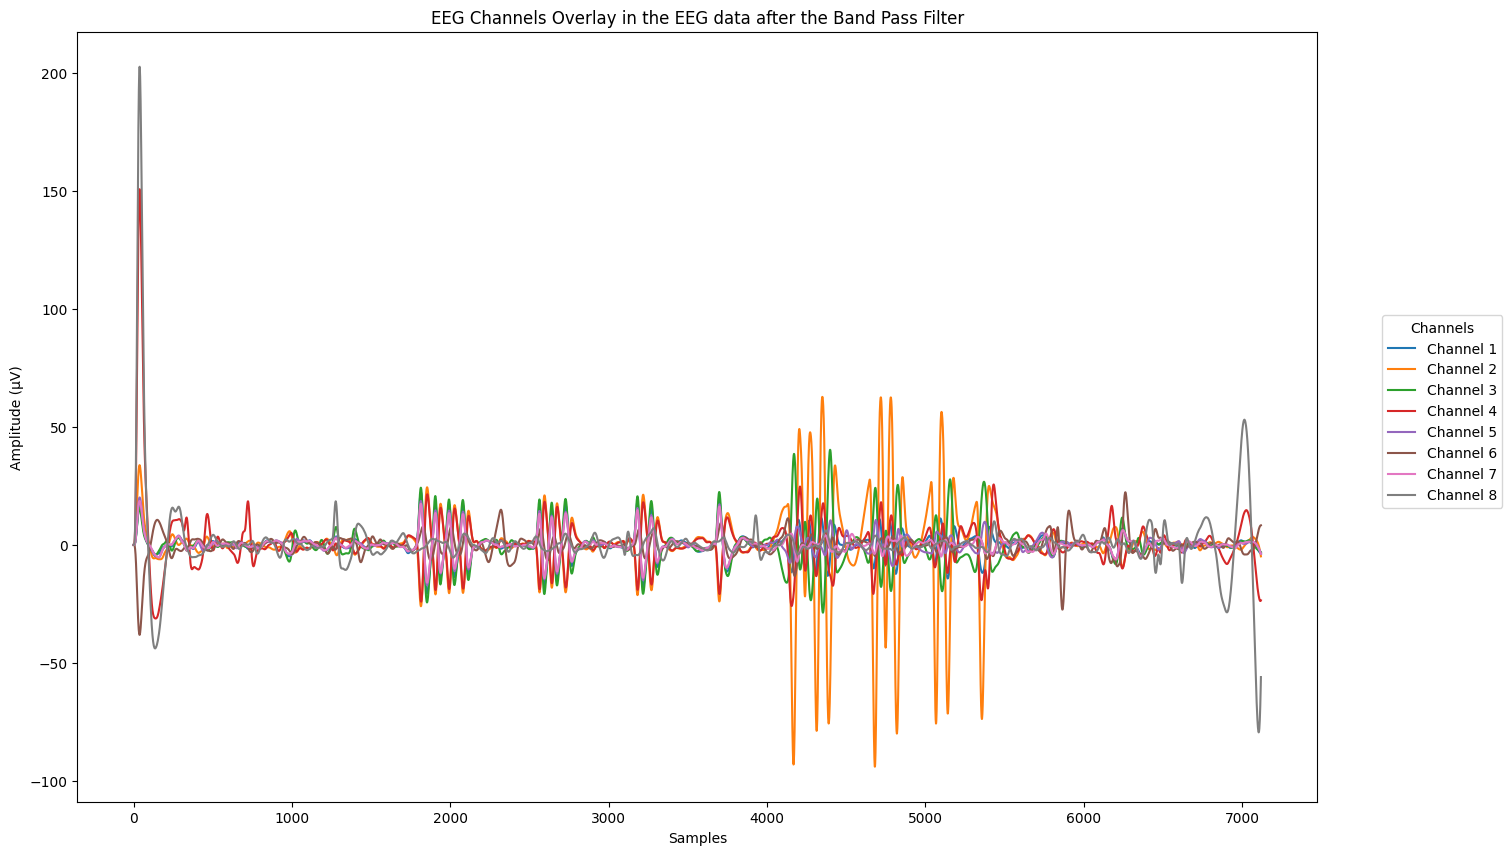

In [14]:
fig, ax = plt.subplots(1, figsize=(16,10))

for index in range(8):
    ax.plot(eeg_data_bp_filtered.iloc[:,index], 
                label=f'Channel {index+1}', 
                c=channel_colors[index])

ax.set_title("EEG Channels Overlay in the EEG data after the Band Pass Filter")
ax.set_xlabel("Samples")
ax.set_ylabel("Amplitude (µV)")

fig.legend(loc='center right', 
           bbox_to_anchor=(1.02, 0.5), 
           title='Channels')

plt.show()

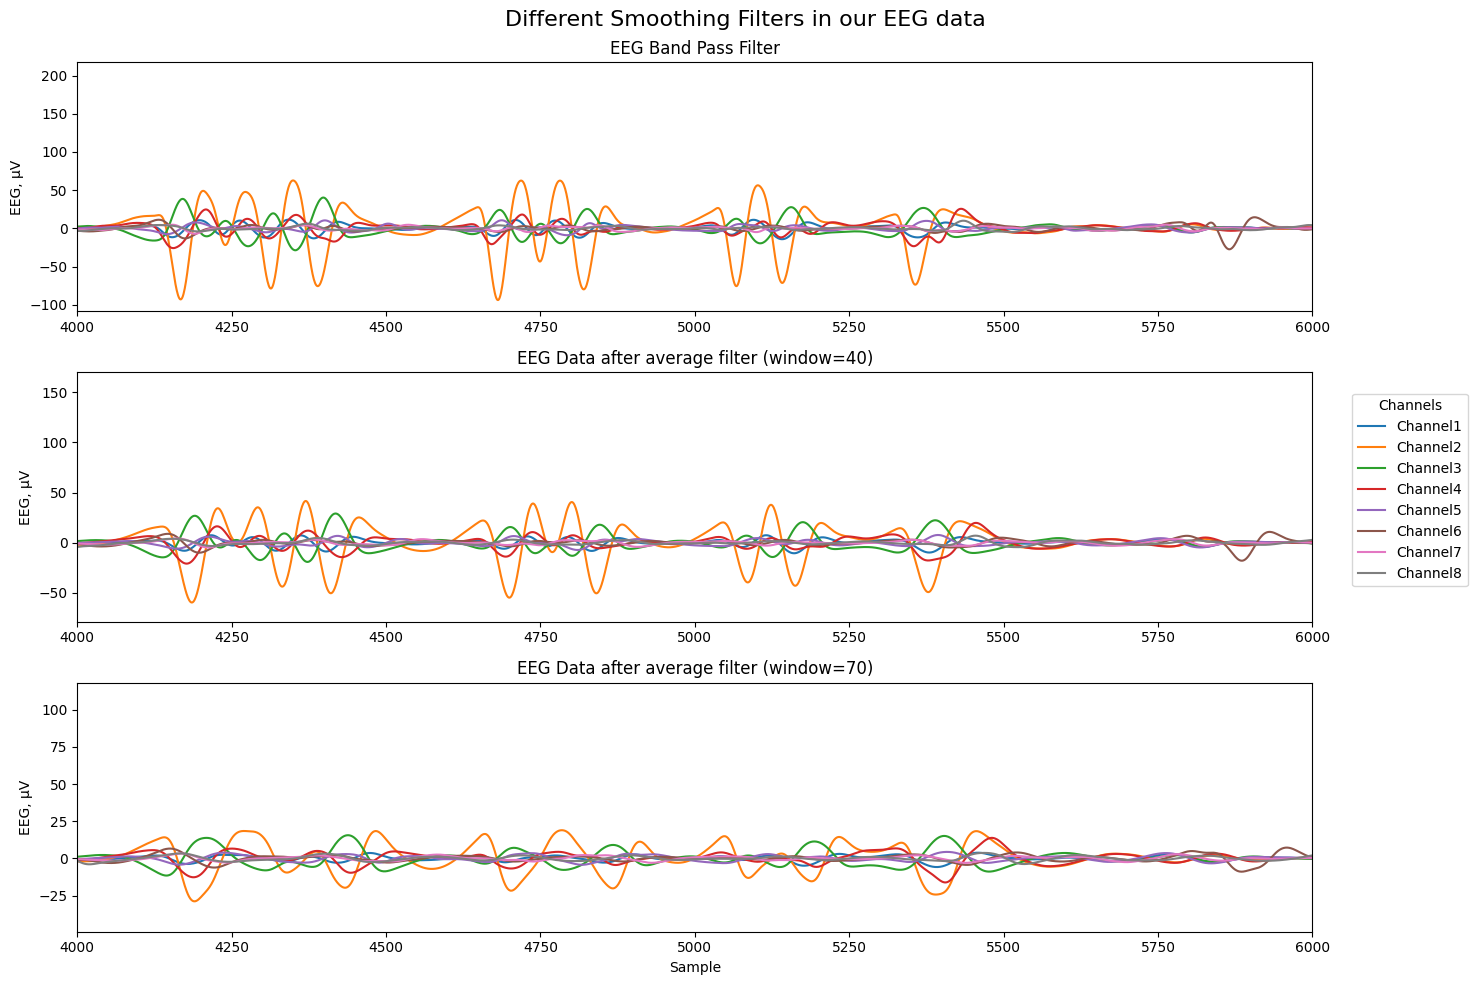

In [15]:
fig, axs = plt.subplots(3,1, figsize=(15,10))

fig.suptitle('Different Smoothing Filters in our EEG data', fontsize=16)

for i in range (8):
    axs[0].plot(eeg_data_bp_filtered.iloc[:,i], 
                c=str(channel_colors[i]),
               )
    axs[1].plot(eeg_data_avg_window_1.iloc[:,i], 
                c=str(channel_colors[i]),
                label=f'Channel{i+1}'
               )
    axs[2].plot(eeg_data_avg_window_2.iloc[:,i], 
                c=str(channel_colors[i]),
               )

for ax in axs:
    ax.set_xlim([4000, 6000])
    ax.set_ylabel('EEG, µV')

axs[0].set_title('EEG Band Pass Filter')
axs[1].set_title('EEG Data after average filter (window=40)')
axs[2].set_title('EEG Data after average filter (window=70)')
axs[-1].set_xlabel('Sample')

fig.legend(loc='center left', 
           bbox_to_anchor=(.9, 0.5),  
           title='Channels')
fig.tight_layout(rect=[0, 0, .9, 1])  # Leave space for the Title and the Legend

plt.show()

## Gaussian Filter

Applying a Gaussian filter to EEG data is a signal processing technique commonly used for smoothing or denoising the signals. Gaussian filtering is a linear smoothing filter that uses a Gaussian kernel to convolve with the EEG signal, effectively reducing noise and emphasizing underlying trends or features.  

**Positive**  

* **Noise Smoothing.** Gaussian filters smooth out noise in the EEG signal, helping to reduce random fluctuations caused by artifacts and environmental interference.
* **Preserving Temporal Details.** Unlike simple moving average filters, Gaussian filters preserve finer temporal features by attenuating noise while maintaining sharp signal transitions.
* **Event-Related Potentials (ERPs).** Gaussian filters are well-suited for enhancing ERP components, such as P300 responses, by reducing noise without distorting the underlying event-related activity.
* **Spatial Smoothing.** For EEG recordings with multiple electrodes (scalp channels), Gaussian filters can be applied across neighboring channels to improve signal-to-noise ratio and reveal broader neural patterns.
* **Frequency-Selective Smoothing.** By adjusting the width of the Gaussian kernel, is ir possibly selectively smooths specific frequency ranges in the EEG signal, making it useful for targeting noise reduction in certain frequency bands.

**Negative**

* **Kernel Size.** The width of the Gaussian kernel (often determined by the standard deviation) impacts the amount of smoothing. Smaller standard deviations preserve more detail, while larger values provide more smoothing.
* **Signal Distortion.** Excessive smoothing can blur rapid changes and transient responses, potentially masking important features in the EEG data.
* **Artifact Handling.** While Gaussian filters can reduce random noise, they might not be as effective at removing structured artifacts like muscle artifacts. Additional preprocessing steps might be needed.
* **Parameter Selection.** The choice of kernel size (standard deviation) depends on your specific analysis goals and the characteristics of your EEG data. Experimentation and validation are crucial.

**How it works**
   
A Gaussian filter for EEG works by convolving the EEG signal with a Gaussian-shaped curve. This curve assigns more weight to nearby data points and gradually decreases the weight as distance from the center increases. *The width of the Gaussian curve, controlled by its standard deviation*, **determines the level of smoothing:**
1. smaller standard deviations maintain fine details, while
2. larger values yield more smoothing.

This makes Gaussian filters suitable for enhancing event-related potentials and reducing noise while retaining temporal precision.

#### We will use our `first_channel_data_bp_filtered` data to compare

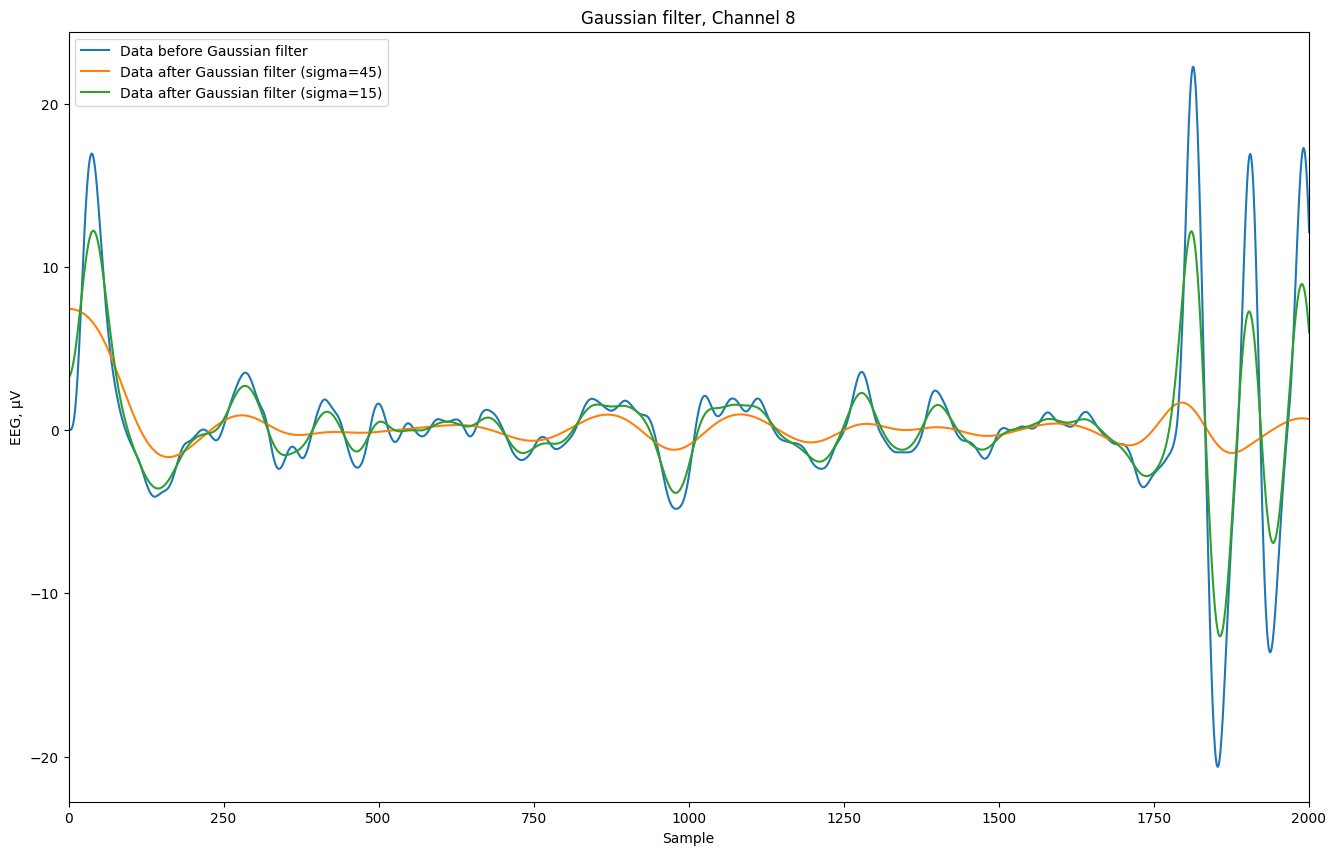

In [16]:
from scipy.ndimage import gaussian_filter1d

# You can control the "smoothness" of the data by changing the kernel's standard deviation value
# Standard Desviation is this symbol σ  represented by sigma. Standard deviation of the Gaussian kernel

sigma_value_1 = 45 
sigma_value_2 = 15

first_channel_data_gauss_window_1 = gaussian_filter1d(first_channel_data_bp_filtered, 
                                                sigma=sigma_value_1)

first_channel_data_gauss_window_2 = gaussian_filter1d(first_channel_data_bp_filtered, 
                                                sigma=sigma_value_2)

fig, ax = plt.subplots(1, figsize=(16,10))
plt.title("Gaussian filter, Channel " +  str(channel+1))
plt.xlabel("Sample")
plt.ylabel("EEG, µV")

plt.plot(first_channel_data_bp_filtered, 
         label='Data before Gaussian filter')

plt.plot(first_channel_data_gauss_window_1, 
         label='Data after Gaussian filter (sigma='+str(sigma_value_1)+")")

plt.plot(first_channel_data_gauss_window_2, 
         label='Data after Gaussian filter (sigma='+str(sigma_value_2)+")")

plt.legend(loc='upper left')
plt.xlim([0, 2000])  # zoom in the data
plt.show()

### Increasing σ (standard deviation)

- The image will become more blurred, similar to the average filter but in a more weighted manner where pixels closer to the center of the kernel have more influence.
- A larger σ results in a broader Gaussian curve, which smooths the image more extensively. This is effective for noise reduction but can also blur important features and edges. The Gaussian filter preserves edges better than the average filter due to its weighted nature.

### Decreasing σ (standard deviation)
    
- The data will experience less blurring, with more details and edges remaining intact.  
- A smaller σ means a narrower Gaussian curve, leading to less smoothing.
- This allows more fine details to be preserved, making it suitable for applications where edge preservation is critical.


## Median filter

Using the median filter for EEG data is another signal processing technique that can be useful for denoising and removing outliers. The median filter replaces each data point with the median value within its neighboring window, which is effective in reducing random noise while preserving sharp edges or features in the signal.  

**Positive**  

* Artifact Removal: Median filters are effective at removing transient artifacts like spikes and sharp fluctuations caused by muscle activity or electrode movement. They're particularly adept at preserving the integrity of the original signal during artifact removal.
* Impulsive Noise: EEG recordings can be affected by impulsive noise that causes isolated extreme values. Median filters are excellent at suppressing these isolated outliers without altering the rest of the signal.
* Preserving Features: Unlike some smoothing filters, median filters do not excessively blur or distort sharp features such as event-related potentials (ERPs) or transient neural responses.
*  Baseline Correction: Median filters can be used for baseline correction, especially in cases where the baseline exhibits sudden variations.

**Negative**

* Smoothing: Median filters are not well-suited for smoothing continuous, gradual changes in EEG signals. They are designed to remove isolated outliers and sharp transients, so they may not effectively address slowly varying noise or baseline drift.
* Frequency-Specific Analysis: Median filters are not frequency-selective like band-pass filters. If you are specifically interested in analyzing frequency components of the EEG signal, using a median filter could distort these components.
* Event-Related Potentials (ERPs): While median filters can preserve sharp features, they might not be suitable for enhancing ERPs, as ERPs often require specialized preprocessing methods that maintain the temporal integrity of the responses.
* Signal Distortion: Median filters can cause signal distortion, especially if the filter's window size is too large. This distortion can impact the shape and timing of certain EEG components.
* Edge Effects: Median filters can introduce artifacts at the edges of the data, affecting the beginning and end of the filtered signal. Proper handling of these edge effects is essential.
* Baseline Drift: Median filters might not effectively remove slow baseline drifts, which require different techniques such as polynomial fitting or high-pass filtering.
* Non-Impulsive Noise: Median filters are most effective against impulsive noise. If the noise in your EEG signal is not primarily impulsive, other filtering methods might be more appropriate.

**How it works**  

A median filter for EEG works by replacing each data point in the signal with the median value of neighboring data points within a defined window. This process effectively reduces isolated spikes, impulsive noise, and sharp transients in the signal while preserving the integrity of sharp features.

1. Window Selection: The filter defines a neighborhood (window) around each pixel or data point.
2. Value Collection: It collects all values within this window.
3. Sorting: The collected values are arranged in numerical order.
4. Replacement: The original value is replaced with the median (middle value) from the sorted list.


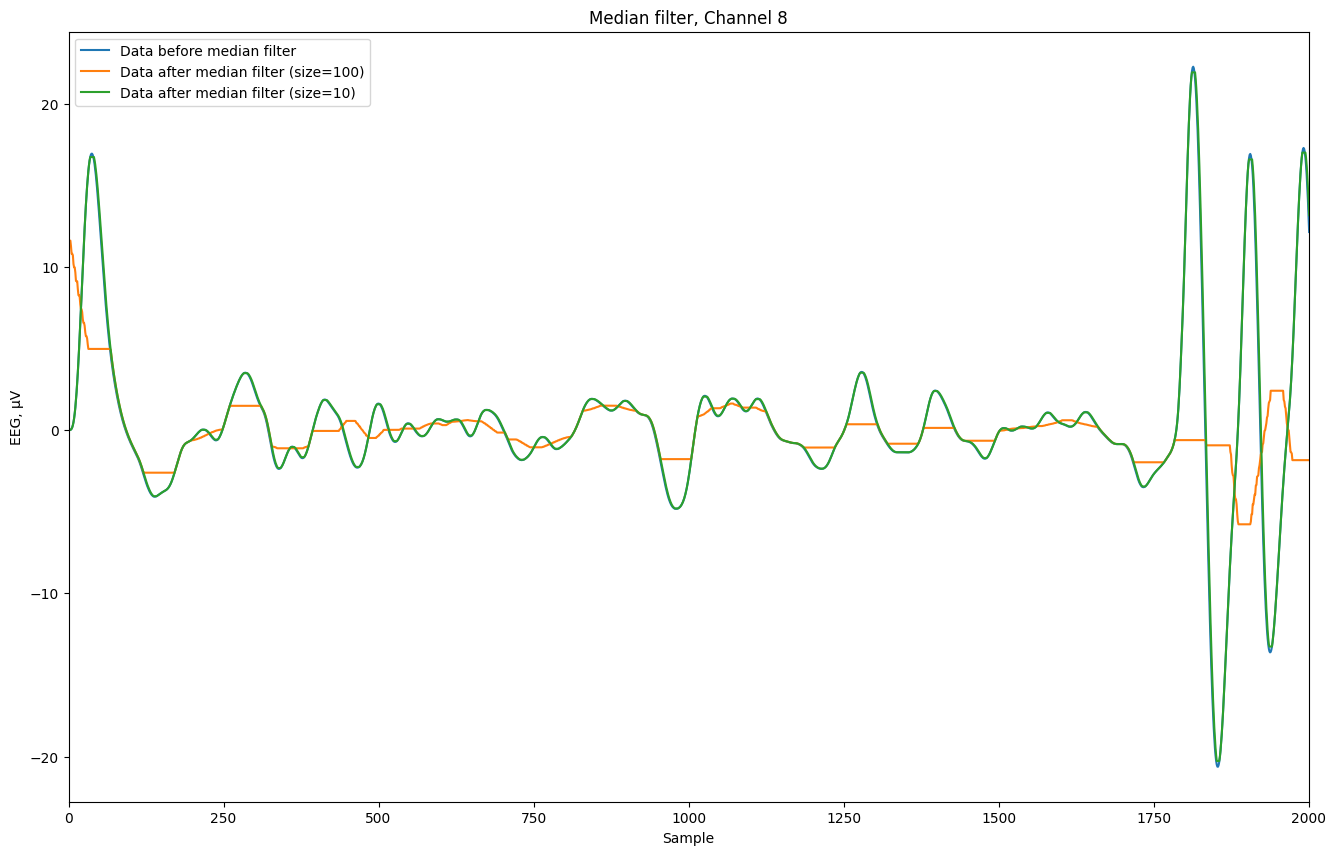

In [17]:
from scipy import ndimage

# you can control the "smoothness" of the data by changing the window size
size_window_1 = 100
size_window_2 = 10

channel_data_median_window_1 = ndimage.median_filter(first_channel_data_bp_filtered, 
                                                     size=size_window_1)  # size It defines the size of the window for the median filter operation
channel_data_median_window_2 = ndimage.median_filter(first_channel_data_bp_filtered, 
                                                     size=size_window_2)


fig, ax = plt.subplots(1, figsize=(16,10))

plt.title("Median filter, Channel " +  str(channel+1))
plt.xlabel("Sample")
plt.ylabel('EEG, µV')

plt.plot(first_channel_data_bp_filtered, 
         label='Data before median filter')
plt.plot(channel_data_median_window_1, 
         label='Data after median filter (size='+str(size_window_1)+")")
plt.plot(channel_data_median_window_2, 
         label='Data after median filter (size='+str(size_window_2)+")")

plt.legend(loc='upper left')
plt.xlim([0, 2000])
plt.show()

### Increase the window size  

- The image will become smoother, with a more significant reduction in noise. Larger features may start to blur.    
- A larger window size provides more robust noise reduction, particularly for high-intensity noise spikes. However, it can also lead to the blurring of important details and edges, similar to the effects seen with larger average or Gaussian filters.  

### Decreasing the window size
   
- The image will retain more fine details and edges while still reducing noise, though less effectively for larger noise spikes.  
- A smaller window size offers less aggressive noise reduction, which helps maintain image details and edges. This is beneficial when the image contains significant fine details or when only light noise reduction is needed.  